# Train RNN_RNN

In [1]:
import os

import numpy as np
import pandas as pd
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_

from tqdm import tqdm

from utils.GloveMgr import GloveMgr
from utils.Dataset import Dataset
from utils.DataLoader import DataLoader
from utils.preprocess_df import preprocess_df
from utils.accuracy_nb_sent_per_doc import accuracy_nb_sent_per_doc_fn
from utils.accuracy_prop_sent_per_doc import accuracy_prop_sent_per_doc_fn

from models.RNN_RNN import RNN_RNN

from time import time

import json
import argparse

In [2]:
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## (Hyper-)parameters

In [4]:
# Parse args if script mode
parser = argparse.ArgumentParser(description='extractive summary')

parser.add_argument('-is_graphic',type=int,default=1,choices=[0,1])
parser.add_argument('-gpu_num',type=int,default=0)
parser.add_argument('-batch_size',type=int,default=32)
parser.add_argument('-epochs',type=int,default=10)

args = None

if is_notebook():
    args = parser.parse_args("")
else:
    args = parser.parse_args()

In [5]:
# parameters
is_graphic = args.is_graphic != 0
cuda_num = args.gpu_num
embed_name = "glove.6B.100"

# hyper-parameters
vocab_size = 150000
batch_size = args.batch_size
epochs = args.epochs
learning_rate = 1e-3
model_name = "RNN_RNN"
sub_folder_name = "model_name__{}__time__{}__embed_name__{}__lr__{}__batch_size__{}__vocab_size__{}__cuda_num__{}".format(model_name, time(), embed_name, learning_rate, batch_size, vocab_size, cuda_num)
checkpoints_folder = "./checkpoints/" + sub_folder_name
average_proportion_of_sentences_per_document = 0.1988573738916917# 0.2670278281534701
average_number_of_sentences_per_document = 6.061850780738518

# print
print("parse:")
print("is_graphic:", is_graphic)
print("cuda_num:", cuda_num)
print("epochs", epochs)
print("batch_size", batch_size)

parse:
is_graphic: True
cuda_num: 0
epochs 10
batch_size 32


## PyTorch initialisation

In [6]:
# Check if a GPU is available
if torch.cuda.is_available():
    # Display the number of available GPUs
    print(f"Number of available GPUs: {torch.cuda.device_count()}")
    # Display the name of each GPU
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available.")

Number of available GPUs: 7
GPU 0: NVIDIA GeForce GTX 1080 Ti
GPU 1: NVIDIA GeForce GTX 1080 Ti
GPU 2: NVIDIA GeForce GTX 1080 Ti
GPU 3: NVIDIA GeForce GTX 1080 Ti
GPU 4: NVIDIA GeForce GTX 1080
GPU 5: NVIDIA GeForce GTX 1080
GPU 6: NVIDIA GeForce GTX 1080


In [7]:
if torch.cuda.is_available():  
  dev = "cuda:" + str(cuda_num) 
else:  
  dev = "cpu" 

device = torch.device(dev)
device

device(type='cuda', index=0)

## Functions

In [8]:
def average(l):
    return sum(l) / len(l)

## Chargement des données

In [9]:
glovemgr = GloveMgr("./data/glove.6B/glove.6B.100d.txt", vocab_size=vocab_size)

In [10]:
df = pd.read_json("data/nyt_corpus_LDC2008T19_50.json")
df = shuffle(df)

df_test = df.iloc[0:3452]
df_val = df.iloc[3452:7452]
df_train = df.iloc[7452:]

In [11]:
train_dataset = Dataset(preprocess_df(df_train, glovemgr=glovemgr, doc_column_name = "docs", labels_column_name="labels", is_sep_n=False, remove_stop_word=True, stemming=False, trunc_sent=50, padding_sent=50, trunc_doc=100))
train_iter = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [12]:
val_dataset = Dataset(preprocess_df(df_val, glovemgr=glovemgr, doc_column_name = "docs", labels_column_name="labels", is_sep_n=False, remove_stop_word=True, stemming=False, trunc_sent=50, padding_sent=50, trunc_doc=100))
val_iter = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [25]:
a = 0
d = 0

for i in range(len(train_dataset)):
  if len(train_dataset[i]["docs"]) != len(train_dataset[i]["labels"]):
    a += 1
    d += abs(len(train_dataset[i]["docs"]) - len(train_dataset[i]["labels"]))

print("Nombre de document avec erreur: {}".format(a))
print("Nombre de phrase en +/- : {}".format(d/a))

Nombre de document avec erreur: 61201
Nombre de phrase en +/- : 1.8896096469011945


## Model

In [13]:
model = RNN_RNN(device=device, vocab_size=vocab_size, word_embed=glovemgr.getEmbeddings())

In [14]:
model.to(device)

RNN_RNN(
  (word_embedding): Embedding(150002, 100)
  (word_GRU): GRU(100, 200, batch_first=True, bidirectional=True)
  (sent_GRU): GRU(400, 200, batch_first=True, bidirectional=True)
  (rel_pos_emb): Embedding(11, 100)
  (abs_pos_emb): Embedding(100, 100)
  (Wdoc): Linear(in_features=400, out_features=400, bias=True)
  (Wcontent): Linear(in_features=400, out_features=1, bias=False)
  (Wsalience): Bilinear(in1_features=400, in2_features=400, out_features=1, bias=False)
  (Wnovelty): Bilinear(in1_features=400, in2_features=400, out_features=1, bias=False)
  (Wabs_pos): Linear(in_features=100, out_features=1, bias=False)
  (Wrel_pos): Linear(in_features=100, out_features=1, bias=False)
)

In [15]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

mae_fn = nn.L1Loss()

## Train

In [16]:
if not os.path.exists(checkpoints_folder):
    os.makedirs(checkpoints_folder)

In [21]:
arr_train_loss = []
arr_train_mae = []
arr_train_acc = []
arr_val_loss = []
arr_val_mae = []
arr_val_acc = []

t1 = time()
for epoch in range(1, epochs+1):
    # train 1 epoch
    model.train()
    nb_batch_train = 0
    total_train_loss = 0
    total_train_mae = 0
    total_train_acc = 0
    with tqdm(train_iter, unit="batch", total=len(train_iter)) as tepoch:
        for batch in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            features = []
            doc_lens = []

            for j in range(batch_size):
                doc_lens.append(len(batch[j]["docs"]))
                features = features + batch[j]["docs"]
            
            features = torch.tensor(features, dtype=torch.long).to(device)

            targets = [torch.tensor(batch[j]["labels"], dtype=torch.float) for j in range(batch_size)]
            targets = torch.cat(targets)
            targets = targets.to(device)
            
            probs = model(features, doc_lens)
            if probs.shape[0] != targets.shape[0]:
                print("fail batch", i)
                continue
            else:
                loss = loss_fn(probs, targets)
                optimizer.zero_grad()
                loss.backward()
                clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                nb_batch_train += 1
                total_train_loss += loss.item()
                total_train_mae += mae_fn(probs, targets).item()
                total_train_acc += accuracy_prop_sent_per_doc_fn(probs=probs.cpu().detach().numpy(), targets=targets.cpu().detach().numpy(), doc_lens=doc_lens, average_proportion_of_sentences_per_document=average_proportion_of_sentences_per_document)
            tepoch.set_postfix(loss=total_train_loss/nb_batch_train, mae=total_train_mae/nb_batch_train, accuracy=total_train_acc/nb_batch_train)
    # Save model
    model.save(checkpoints_folder + "/" + model_name + "-" + str(epoch) + ".pt")
    # Show train and val score
    model.eval()
    nb_batch_val = 0
    total_val_loss = 0
    total_val_mae = 0
    total_val_acc = 0
    for i,batch in enumerate(val_iter):
        features = []
        doc_lens = []

        for j in range(batch_size):
            doc_lens.append(len(batch[j]["docs"]))
            features = features + batch[j]["docs"]
            
        features = torch.tensor(features, dtype=torch.long).to(device)

        targets = [torch.tensor(batch[j]["labels"], dtype=torch.float) for j in range(batch_size)]
        targets = torch.cat(targets)
        targets = targets.to(device)
        
        probs = model(features, doc_lens)
        
        if probs.shape[0] != targets.shape[0]:
            print("fail batch", i)
            continue
        else:
            loss = loss_fn(probs, targets)
            nb_batch_val += 1
            total_val_loss += loss.item()
            total_val_mae += mae_fn(probs, targets).item()
            total_val_acc += accuracy_prop_sent_per_doc_fn(probs=probs.cpu().detach().numpy(), targets=targets.cpu().detach().numpy(), doc_lens=doc_lens, average_proportion_of_sentences_per_document=average_proportion_of_sentences_per_document)
    print("Epoch {} : train loss = {:.3f}, val loss = {:.3f}, train mae = {:.3f}, val mae = {:.3f}, train accuracy = {:.3f}, val accuracy = {:.3f}".format(epoch, total_train_loss / nb_batch_train, total_val_loss / nb_batch_val, total_train_mae / nb_batch_train, total_val_mae / nb_batch_val, total_train_acc / nb_batch_train, total_val_acc / nb_batch_val))

    arr_train_loss.append(total_train_loss / nb_batch_train)
    arr_train_mae.append(total_train_mae / nb_batch_train)
    arr_train_acc.append(total_train_acc / nb_batch_train)

    arr_val_loss.append(total_val_loss / nb_batch_val)
    arr_val_mae.append(total_val_mae / nb_batch_val)
    arr_val_acc.append(total_val_acc / nb_batch_val)

t2 = time()
print("Training duration =", t2-t1)

Epoch 1:   0%|          | 1/4027 [00:00<35:32,  1.89batch/s]

fail batch 6


Epoch 1:   0%|          | 2/4027 [00:00<24:58,  2.69batch/s]

fail batch 6


Epoch 1:   0%|          | 3/4027 [00:01<22:17,  3.01batch/s]

fail batch 6


Epoch 1:   0%|          | 4/4027 [00:01<22:19,  3.00batch/s]

fail batch 6


Epoch 1:   0%|          | 5/4027 [00:01<21:42,  3.09batch/s]

fail batch 6


Epoch 1:   0%|          | 6/4027 [00:02<21:20,  3.14batch/s]

fail batch 6


Epoch 1:   0%|          | 7/4027 [00:02<20:30,  3.27batch/s]

fail batch 6


Epoch 1:   0%|          | 8/4027 [00:02<20:33,  3.26batch/s]

fail batch 6


Epoch 1:   0%|          | 9/4027 [00:02<19:59,  3.35batch/s]

fail batch 6


Epoch 1:   0%|          | 10/4027 [00:03<20:37,  3.25batch/s]

fail batch 6


Epoch 1:   0%|          | 11/4027 [00:03<20:29,  3.27batch/s]

fail batch 6


Epoch 1:   0%|          | 12/4027 [00:03<20:38,  3.24batch/s]

fail batch 6


Epoch 1:   0%|          | 13/4027 [00:04<20:46,  3.22batch/s]

fail batch 6


Epoch 1:   0%|          | 14/4027 [00:04<20:31,  3.26batch/s]

fail batch 6


Epoch 1:   0%|          | 15/4027 [00:04<20:16,  3.30batch/s]

fail batch 6


Epoch 1:   0%|          | 16/4027 [00:05<20:00,  3.34batch/s]

fail batch 6


Epoch 1:   0%|          | 17/4027 [00:05<20:48,  3.21batch/s]

fail batch 6


Epoch 1:   0%|          | 18/4027 [00:05<21:01,  3.18batch/s]

fail batch 6


Epoch 1:   0%|          | 19/4027 [00:06<20:54,  3.20batch/s]

fail batch 6


Epoch 1:   0%|          | 20/4027 [00:06<22:06,  3.02batch/s]

fail batch 6


Epoch 1:   1%|          | 21/4027 [00:06<20:30,  3.26batch/s]

fail batch 6


Epoch 1:   1%|          | 22/4027 [00:06<20:11,  3.31batch/s]

fail batch 6


Epoch 1:   1%|          | 23/4027 [00:07<19:33,  3.41batch/s]

fail batch 6


Epoch 1:   1%|          | 24/4027 [00:07<18:48,  3.55batch/s]

fail batch 6


Epoch 1:   1%|          | 25/4027 [00:07<18:17,  3.65batch/s]

fail batch 6


Epoch 1:   1%|          | 26/4027 [00:07<17:36,  3.79batch/s]

fail batch 6


Epoch 1:   1%|          | 27/4027 [00:08<16:46,  3.97batch/s]

fail batch 6


Epoch 1:   1%|          | 28/4027 [00:08<17:13,  3.87batch/s]

fail batch 6


Epoch 1:   1%|          | 29/4027 [00:08<16:58,  3.92batch/s]

fail batch 6


Epoch 1:   1%|          | 30/4027 [00:08<16:39,  4.00batch/s]

fail batch 6


Epoch 1:   1%|          | 32/4027 [00:09<15:12,  4.38batch/s]

fail batch 6
fail batch 6


Epoch 1:   1%|          | 33/4027 [00:09<15:56,  4.18batch/s]

fail batch 6


Epoch 1:   1%|          | 34/4027 [00:09<16:01,  4.15batch/s]

fail batch 6


Epoch 1:   1%|          | 35/4027 [00:10<15:31,  4.29batch/s]

fail batch 6


Epoch 1:   1%|          | 36/4027 [00:10<15:20,  4.34batch/s]

fail batch 6


Epoch 1:   1%|          | 37/4027 [00:10<15:37,  4.25batch/s]

fail batch 6


Epoch 1:   1%|          | 38/4027 [00:10<15:32,  4.28batch/s]

fail batch 6


Epoch 1:   1%|          | 39/4027 [00:11<16:05,  4.13batch/s]

fail batch 6


Epoch 1:   1%|          | 40/4027 [00:11<16:08,  4.12batch/s]

fail batch 6


Epoch 1:   1%|          | 41/4027 [00:11<15:56,  4.17batch/s]

fail batch 6


Epoch 1:   1%|          | 42/4027 [00:11<16:02,  4.14batch/s]

fail batch 6


Epoch 1:   1%|          | 43/4027 [00:11<15:41,  4.23batch/s]

fail batch 6


Epoch 1:   1%|          | 44/4027 [00:12<15:25,  4.30batch/s]

fail batch 6


Epoch 1:   1%|          | 45/4027 [00:12<15:35,  4.25batch/s]

fail batch 6


Epoch 1:   1%|          | 46/4027 [00:12<16:27,  4.03batch/s]

fail batch 6


Epoch 1:   1%|          | 47/4027 [00:12<16:08,  4.11batch/s]

fail batch 6


Epoch 1:   1%|          | 48/4027 [00:13<16:15,  4.08batch/s]

fail batch 6


Epoch 1:   1%|          | 49/4027 [00:13<16:20,  4.06batch/s]

fail batch 6


Epoch 1:   1%|▏         | 51/4027 [00:13<15:10,  4.37batch/s]

fail batch 6
fail batch 6


Epoch 1:   1%|▏         | 52/4027 [00:14<15:14,  4.35batch/s]

fail batch 6


Epoch 1:   1%|▏         | 53/4027 [00:14<15:49,  4.19batch/s]

fail batch 6


Epoch 1:   1%|▏         | 54/4027 [00:14<15:44,  4.21batch/s]

fail batch 6


Epoch 1:   1%|▏         | 55/4027 [00:14<16:06,  4.11batch/s]

fail batch 6


Epoch 1:   1%|▏         | 56/4027 [00:15<15:40,  4.22batch/s]

fail batch 6


Epoch 1:   1%|▏         | 57/4027 [00:15<16:23,  4.04batch/s]

fail batch 6


Epoch 1:   1%|▏         | 58/4027 [00:15<16:20,  4.05batch/s]

fail batch 6


Epoch 1:   1%|▏         | 59/4027 [00:15<16:28,  4.01batch/s]

fail batch 6


Epoch 1:   1%|▏         | 60/4027 [00:16<16:18,  4.05batch/s]

fail batch 6


Epoch 1:   2%|▏         | 61/4027 [00:16<16:32,  4.00batch/s]

fail batch 6


Epoch 1:   2%|▏         | 62/4027 [00:16<15:57,  4.14batch/s]

fail batch 6


Epoch 1:   2%|▏         | 63/4027 [00:16<15:40,  4.21batch/s]

fail batch 6


Epoch 1:   2%|▏         | 64/4027 [00:17<15:33,  4.25batch/s]

fail batch 6


Epoch 1:   2%|▏         | 65/4027 [00:17<15:04,  4.38batch/s]

fail batch 6


Epoch 1:   2%|▏         | 66/4027 [00:17<15:12,  4.34batch/s]

fail batch 6


Epoch 1:   2%|▏         | 67/4027 [00:17<15:39,  4.21batch/s]

fail batch 6


Epoch 1:   2%|▏         | 68/4027 [00:17<15:45,  4.19batch/s]

fail batch 6


Epoch 1:   2%|▏         | 69/4027 [00:18<15:39,  4.21batch/s]

fail batch 6


Epoch 1:   2%|▏         | 70/4027 [00:18<16:10,  4.08batch/s]

fail batch 6


Epoch 1:   2%|▏         | 71/4027 [00:18<15:49,  4.17batch/s]

fail batch 6


Epoch 1:   2%|▏         | 72/4027 [00:18<16:14,  4.06batch/s]

fail batch 6


Epoch 1:   2%|▏         | 73/4027 [00:19<15:53,  4.15batch/s]

fail batch 6


Epoch 1:   2%|▏         | 74/4027 [00:19<16:02,  4.11batch/s]

fail batch 6


Epoch 1:   2%|▏         | 75/4027 [00:19<17:23,  3.79batch/s]

fail batch 6


KeyboardInterrupt: 

In [ ]:
training_metrics = {}
training_metrics["duration"]   = t2 - t1
training_metrics["train_loss"] = arr_train_loss
training_metrics["train_mae"]  = arr_train_mae
training_metrics["train_acc"]  = arr_train_acc
training_metrics["val_loss"]   = arr_val_loss
training_metrics["val_mae"]    = arr_val_mae
training_metrics["val_acc"]    = arr_val_acc

# Save to file in JSON format

with open(checkpoints_folder + "/training_metrics.json", 'w') as fp:
    json.dump(training_metrics, fp)

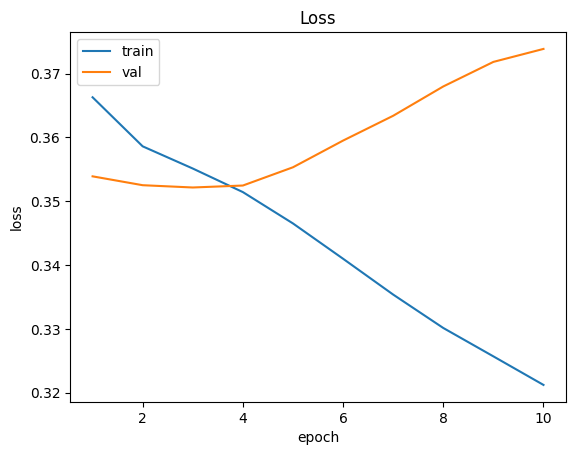

In [ ]:
# draw Losses
if is_graphic:
    plt.plot(list(range(1, len(arr_train_loss) + 1)), arr_train_loss, label="train")
    plt.plot(list(range(1, len(arr_val_loss) + 1)), arr_val_loss, label="val")

    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(loc="upper left")

    plt.show()

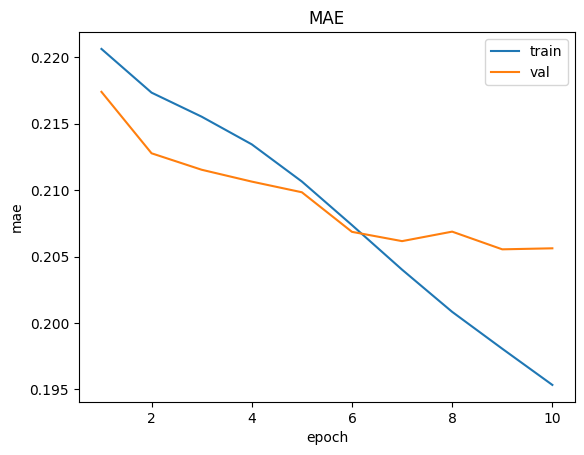

In [ ]:
# draw mae
if is_graphic:
    plt.plot(list(range(1, len(arr_train_mae) + 1)), arr_train_mae, label="train")
    plt.plot(list(range(1, len(arr_val_mae) + 1)), arr_val_mae, label="val")

    plt.title("MAE")
    plt.xlabel("epoch")
    plt.ylabel("mae")
    plt.legend(loc="upper right")

    plt.show()

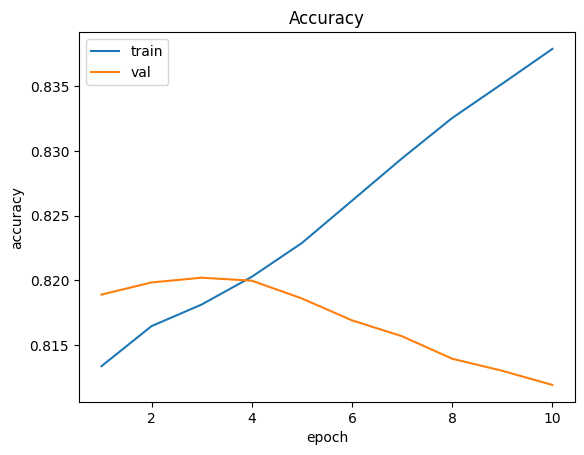

In [ ]:
# draw Accuracies
if is_graphic:
    plt.plot(list(range(1, len(arr_train_acc) + 1)), arr_train_acc, label="train")
    plt.plot(list(range(1, len(arr_val_acc) + 1)), arr_val_acc, label="val")

    plt.title("Accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend(loc="upper left")

    plt.show()

# Eval model

In [ ]:
from utils.split_all_docs import split_all_docs
from rouge_score import rouge_scorer
from utils.threshold_probs import threshold_probs_by_prop

In [ ]:
model = RNN_RNN(device=device, vocab_size=vocab_size, word_embed=glovemgr.getEmbeddings())

In [ ]:
best_epoch = np.argmax(np.array(arr_val_acc)) + 1
model.load(checkpoints_folder + "/" + model_name + "-" + str(best_epoch) + ".pt")
model.to(device)
model.eval()

RNN_RNN(
  (word_embedding): Embedding(150002, 100)
  (word_GRU): GRU(100, 200, batch_first=True, bidirectional=True)
  (sent_GRU): GRU(400, 200, batch_first=True, bidirectional=True)
  (rel_pos_emb): Embedding(11, 100)
  (abs_pos_emb): Embedding(100, 100)
  (Wdoc): Linear(in_features=400, out_features=400, bias=True)
  (Wcontent): Linear(in_features=400, out_features=1, bias=False)
  (Wsalience): Bilinear(in1_features=400, in2_features=400, out_features=1, bias=False)
  (Wnovelty): Bilinear(in1_features=400, in2_features=400, out_features=1, bias=False)
  (Wabs_pos): Linear(in_features=100, out_features=1, bias=False)
  (Wrel_pos): Linear(in_features=100, out_features=1, bias=False)
)

In [ ]:
test_set = pd.read_json("./data/test.json")
test_set["doc_splited"] = split_all_docs(test_set["text"])

In [ ]:
test_dataset = Dataset(preprocess_df(df_test, glovemgr=glovemgr, doc_column_name = "docs", labels_column_name="labels", is_sep_n=False, remove_stop_word=True, stemming=False, trunc_sent=50, padding_sent=50, trunc_doc=100))
test_iter = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

In [ ]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
mae_fn = nn.L1Loss()

In [ ]:
arr_rouge1 = []
arr_rouge2 = []
arr_rougeL = []
mae = []
accuracy = []

idx = 0
with tqdm(test_iter, unit="batch", total=len(test_iter)) as tepoch:
    for batch in tepoch:
        tepoch.set_description("Eval model")
        features = []
        doc_lens = []

        for j in range(1):
            doc_lens.append(len(batch[j]["docs"]))
            features = features + batch[j]["docs"]
                
        features = torch.tensor(features, dtype=torch.long).to(device)

        targets = [torch.tensor(batch[j]["labels"], dtype=torch.float) for j in range(1)]
        targets = torch.cat(targets)
        targets = targets.to(device)

        doc_empty = False
        for doc_len in doc_lens:
            if doc_len == 0 or doc_len == 1:
                doc_empty = True
        if not doc_empty:
            probs = model(features, doc_lens)

            doc = test_set["doc_splited"][idx]
            if len(doc) > 1 and len(doc) == probs.shape[0] and probs.shape[0] == targets.shape[0]:
                probs = torch.tensor(threshold_probs_by_prop(probs=probs.cpu().detach().numpy(), doc_lens=[probs.shape[0]], average_proportion_of_sentences_per_document=average_proportion_of_sentences_per_document+0.1), dtype=torch.float).to(device)
                txt = ""
                
                # print(len(doc), " ==", probs.shape)
                for i in range(len(doc)):
                    if probs[i] == 1:
                        txt = txt + doc[i] + "."

                scores = scorer.score(txt, test_set["summaries"][idx])
                arr_rouge1.append(scores["rouge1"].fmeasure)
                arr_rouge2.append(scores["rouge2"].fmeasure)
                arr_rougeL.append(scores["rougeL"].fmeasure)

                mae.append(mae_fn(probs, targets).item())

                accuracy.append(accuracy_prop_sent_per_doc_fn(probs=probs.cpu().detach().numpy(), targets=targets.cpu().detach().numpy(), doc_lens=doc_lens, average_proportion_of_sentences_per_document=average_proportion_of_sentences_per_document))
                idx += 1
                tepoch.set_postfix(accuracy = average(accuracy), mae = average(mae), rouge1 = average(arr_rouge1), rouge2 = average(arr_rouge2), rougeL = average(arr_rougeL))

Eval model: 100%|██████████| 10350/10350 [01:52<00:00, 92.06batch/s, accuracy=0.795, mae=0.256, rouge1=0.298, rouge2=0.152, rougeL=0.2] 


In [ ]:
test_metrics = {}
test_metrics["accuracy"] = average(accuracy)
test_metrics["mae"]      = average(mae)
test_metrics["rouge1"]   = average(arr_rouge1)
test_metrics["rouge2"]   = average(arr_rouge2)
test_metrics["rougeL"]   = average(arr_rougeL)

# Save to file in JSON format

with open(checkpoints_folder + "/test_metrics.json", 'w') as fp:
    json.dump(test_metrics, fp)

In [ ]:
# Does not excute this cell if you want to execute the following cells.
import sys
sys.exit()

SystemExit: 

/home/rsaid/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Others

In [ ]:
import numpy as np
import json

In [ ]:
# Mesurer la moyenne des resultats
dnames = ["model_name__RNN_RNN__time__1677674712.6719887__embed_name__glove.6B.100__lr__0.001__batch_size__32__vocab_size__150000__cuda_num__0",\
          "model_name__RNN_RNN__time__1677674976.7989237__embed_name__glove.6B.100__lr__0.001__batch_size__32__vocab_size__150000__cuda_num__1",\
          "model_name__RNN_RNN__time__1677675018.309817__embed_name__glove.6B.100__lr__0.001__batch_size__32__vocab_size__150000__cuda_num__2",\
          "model_name__RNN_RNN__time__1677675034.4065497__embed_name__glove.6B.100__lr__0.001__batch_size__32__vocab_size__150000__cuda_num__3",\
          "model_name__RNN_RNN__time__1677675050.3008132__embed_name__glove.6B.100__lr__0.001__batch_size__32__vocab_size__150000__cuda_num__4",\
          "model_name__RNN_RNN__time__1677675073.7586496__embed_name__glove.6B.100__lr__0.001__batch_size__32__vocab_size__150000__cuda_num__5"]

In [ ]:
# Temps d'exécution moyen
training_metrics = [json.load(open("./checkpoints/" + dname + "/training_metrics.json")) for dname in dnames]

durations = np.array([tm["duration"] for tm in training_metrics])

print("mean duration = {}+/-{}".format(np.mean(durations), np.std(durations)))

In [ ]:
# Scores
test_metrics = [json.load(open("./checkpoints/" + dname + "/test_metrics.json")) for dname in dnames]

accuracies = np.array([test_metrics[i]["accuracy"] for i in range(len(test_metrics))])
rouge1 = np.array([test_metrics[i]["rouge1"] for i in range(len(test_metrics))])
rouge2 = np.array([test_metrics[i]["rouge2"] for i in range(len(test_metrics))])
rougeL = np.array([test_metrics[i]["rougeL"] for i in range(len(test_metrics))])

print("accuracy = {}+/-{}".format(np.mean(accuracies), np.std(accuracies)))
print("rouge1 = {}+/-{}".format(np.mean(rouge1), np.std(rouge1)))
print("rouge2 = {}+/-{}".format(np.mean(rouge2), np.std(rouge2)))
print("rougeL = {}+/-{}".format(np.mean(rougeL), np.std(rougeL)))